## The notebook
In this notebook we will first develop a simple hail ML model similar to the one that has ben developed for the UC3. The predictors are a set of ERA5 meteorological variables for the period 2015-2023, while the target are hail observations from the European Severe Weather Database (ESWD). The coverage of these database is quite inconsistent, with a high coverage of observations across Alpine regions and it suroundings (Northern Italy, Austria, Switzerland, Germany), and relatively few observations elsewhere. This is due to the fact that hail is more frequent in peripheria of the Alps, but also due to different dynamics on how the populations report hail. As a consequence, we will train the model in this high hail report area. Additionally, we will transfer this model to Catalonia (Spain), where hail is also very frequent, but the number of observations is lower.   

## The data
The predictors of the model are processed meteorological variables from ERA5. We attach a parquet file (one for Central Europe and one for Catalonia) with a daily value (max, min or mean respectively) for each of the 10 selected variables. Note that our definition of Central Europe includes some areas of Northern Italy, Southern France and the Balcan peninsula. If the variable is an integrated 2 variable, we used the given value. If the variable is a 3d variable with different values across altitude levels, we used the maximum, minimum or mean (respectively) across three altitude (pressure) levels, 850, 700 and 500 hPa. The target of the model (Hail_Event) are hail observations from ESWD. Whenever there was a hail event, this variable is 1, 0 otherwise. Note that because many hail events do not get reported, many of these zero values are incorrect. 

In summary, each parquet file for the train (Central Europe) and inference (Catalonia) regions contains, for each latitude, longitude, year, month and day, a value for each of the 10 predictors, and a Hail_Event value that can be 0 or 1. The year given here is 2015-2023. The first years of the domain contain much less observations than the latests, specially for Catalonia. 

## The model 
We train a XGboost classifier. As the posiive class represents only ~0.2% of the training dataset, we first remove all grids that do not have any observation. In this way we also remove the data where the unlabelling is more likely (if there was never an observation in a grid, it is likely that hail does not get reported there). After this, the inbalance is still large, so we perform an undersampling of the majority class until the minority repreesents ~ 15% of the data. Additionally, we scale all the predictors. 

After the model is train, it is very important to apply a bias correction to the results. This anlaysis has been done separately and not shown here. Although the model captures the spatial and temporal distribution of the hail observations, its absolute magnitude is much higher than expected in areas we we have confidence of good event reporting. This is likely given by the fact that the model is trained using positive unlabeled data (some of the zeros are unalbelled ones). Therefore, we bias correct the output to maike it match the observations. The analysis shows that by muliplying the output probabilty by 0.15, the expected values of the model match the monthly means of observations in cities with high reporting rates.

## Validation
Validating hail models is extremely challenging for two reasons. First, as hail is a relatively rare phenomena, the datasets are highly inbalance. Therefore, we cannot use validation metrics that contain true negatives, whcih are the majority of the dataset and easy to predict. Therefore, we need to use scores that ignore the true negatives, such as MCC or F-beta scores. Additionaly, as mentioned above, many hail events are missing from the report observations. Therefore, the metrics will never show the true skill of the model, asi it is not fully possible to evaluate it. Therefore, we have used two metrics to for our analysis: 
- Matthews Correlation Coefficient (MCC): commonly used in ML, it works well for highly inbalence datasets as it does not use true negatives. However, as it still uses false positives and our dataset is missing lots of observations, we will never obtain a good MCC score. We will focus on it for the evaluation of the base model.
- F' score: This score is not commonly used in ML. However, it is a good score for a dataset with unlabelled positive examples. It can be regarded as an equivalent of $F_1$ metrics, $\tilde{F}_1 = \frac{r²}{p(\hat{y}=1)}$, where $r$ is recall, in the reference dataset, and ${p(\hat{y}=1)}$ means the fraction of positives predicted by the model. This metric will favour a high recall (number of positives detected by the model) with the lowest possibe modelled positives. We will use this score to evaluate the transfer learning techniques. 


# The code
## Importing functions and defining variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as crs
from shapely.geometry import Point
import geopandas as gpd

from functions import plot_processed_cdd_data, train_data, inference_data, classifier_xgboost, plot_mcc_alpha

# Predictors of the model
model_columns=["totalx_max","cape_max","w_min","p80.162_max","d_min","q_max","cp_max","tciw_max","deg0l_max","sp_mean"]

# Parameters of the XGBoost classifier
model_parameters={
    "objective": "binary:logistic",
    #"class_weight": "balanced",
    "random_state": 43,
    "learning_rate": 0.05, 
    "max_depth": 5, 
    "n_estimators": 100
}

# Bias correction factor (explained above)
calibration_factor=0.15

# paths to datafiles
path_central_europe="/home/jovyan/data/koios/transfer_learning/koios_data_central_europe.parquet"
path_catalonia="/home/jovyan/data/koios/transfer_learning/koios_data_catalonia.parquet"

## Training a baseline classifier
First we will train a base classifier in central Europe and use it to make an inference there to see how the prediction looks like. Then, we will transfer it to Catalonia without any covariate shift methodology. 

#### Reading and processing data for Central Europe and Catalonia

In [4]:
# Note the Central Europe data is processed twice, once for training, where the locations without any event are removed, and one full, for the inference 
# For training, we use the years 2015-2021 for training and 2022-2023 for evaluation
training_data=train_data(path_central_europe,np.arange(2015,2022),[2022,2023],model_columns,remove_areas_without_events=True)
training_data_for_inference=inference_data(path_central_europe,np.arange(2022,2024),model_columns,training_data)

# Getting data for Catalonia for inference
catalonia_for_inference=inference_data(path_catalonia,np.arange(2015,2024),model_columns,training_data)

In [10]:
training_data.X_train_scaled_resampled.shape

(21574, 10)

#### Constructing classifier and applying it to train region
Here we use data from the "Central Europe" domain to train a ML classifier (2015-2021). Then we appliy this classifier to the same domain for the years 2022 and 2023. Note although the raw data for train and inference in this case are the same, for train we remove the areas with no events, which improves the metrics. 

In [3]:
### training base classifier
# We get the maximum MCC score for the validation years of the train dataset
base_classifier=classifier_xgboost(training_data,model_parameters)

training...
model trained
Scores on training region (test)
Max MCC: 0.204 (Threshold: 0.650)


Scores on inference region
Max MCC: 0.191 (Threshold: 0.650)
Max F_modified: 12.130 (Threshold: 0.640)


/home/jovyan/KOIOS/dev/transfer_learning_europe/functions.py:191: RuntimeWarning: invalid value encountered in scalar divide
  f_pu = r**2/p


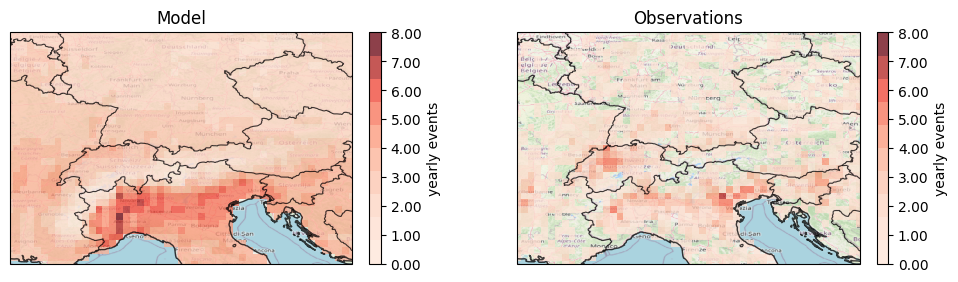

In [4]:
### Applying classifier to Central Europe  
plt.figure(figsize=(12,4))
data_inference_central_europe, max_mcc_value, max_f=base_classifier.make_inference(training_data_for_inference,plot_inference_map=True,calibration_factor=calibration_factor,vmax=8)

The classifier shows a max MCC score of 0.19, which is no bad given the challenge of hail modelling as well as the lack of observations in the database. The spatial distribution of the events looks similar in the model and in the observations, given the different urban/rural/country reporting rates. Note this map looks very similar to another hail model developed by Giordani et al., 2024. 

Note the model is exptected to have more events than the observations. As explained above, the observations are extreely incomplete,a dn the main function of the model is to learn which meteorological environments lead to hail. In this way, the model can "fill the gaps" where observations are mising. 

#### Applying base classifier to inference region (Catalonia)

Scores on inference region
Max MCC: 0.113 (Threshold: 0.600)
Max F_modified: 6.036 (Threshold: 0.560)


/tmp/ipykernel_30/2627209053.py:42: RuntimeWarning: invalid value encountered in scalar divide
  f_pu = r**2/p


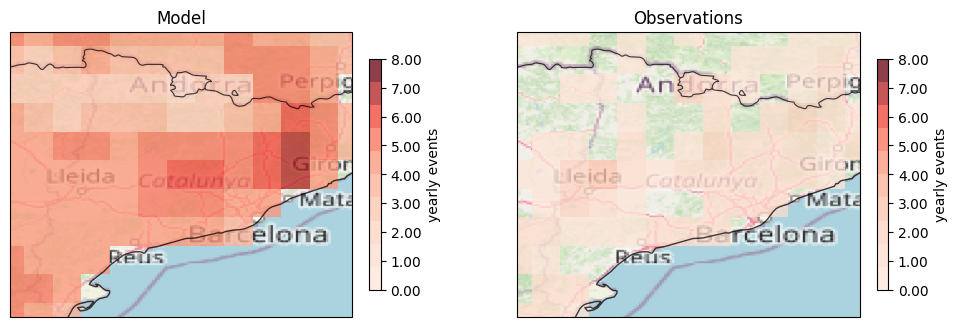

In [47]:
### Applying classifier to Catalonia
plt.figure(figsize=(12,4))
data_inference_central_europe, max_mcc_value, max_f=base_classifier.make_inference(catalonia_for_inference,plot_inference_map=True,calibration_factor=calibration_factor,vmax=8)

This is how the transfer learning methodology looks like in Catalonia. There is a very low amount of hail data in Catalonia, therefore it is difficult to address how the model performs. However, the model still managed to get a maximum MCC score of 0.1. Additionally, this map is in a agreement with the maps produced by the hail model developed by Plunge et al., 2017. Both models show that the hail ocurrence is lower in the high areas of the Pyrenees, and higher in regions such as inner Girona or the Iberian system in Aragon.

# Testing Covariate Shift weighting methodology in Catalonia

First, we study the covariate shift in between the training domain in Central Europe and Catalonia. In this case, the differences will not be massive, as they both incorporates areas of high mountain (the Alps and the Pyrenees) and lowlands. However, there are substantial differences as the Alps reach much higher altitudes and the Central Europe domain contains large fracions of the Great European Plain, which differ substantially to the lowlands of Catalonia. 

In the figure below, we show the difference for each of the 10 used predictors in the training and inference domains. We show the differences for the zeros (no hail) and ones (hail) separately. Some variables such as the Convective Available Potential Energy (CAPE, a very relevant proxy for thunderstorms) are shifted towards higher values in the inference domain than in the training one. This is also visible for other variables such as the specific humidity. Although the shift in the variables is not massive in this case, it can still affect the performance of the model. Additionally, if we want to transfer the model to other regions that are climatically more different, this effect would be even bigger. 


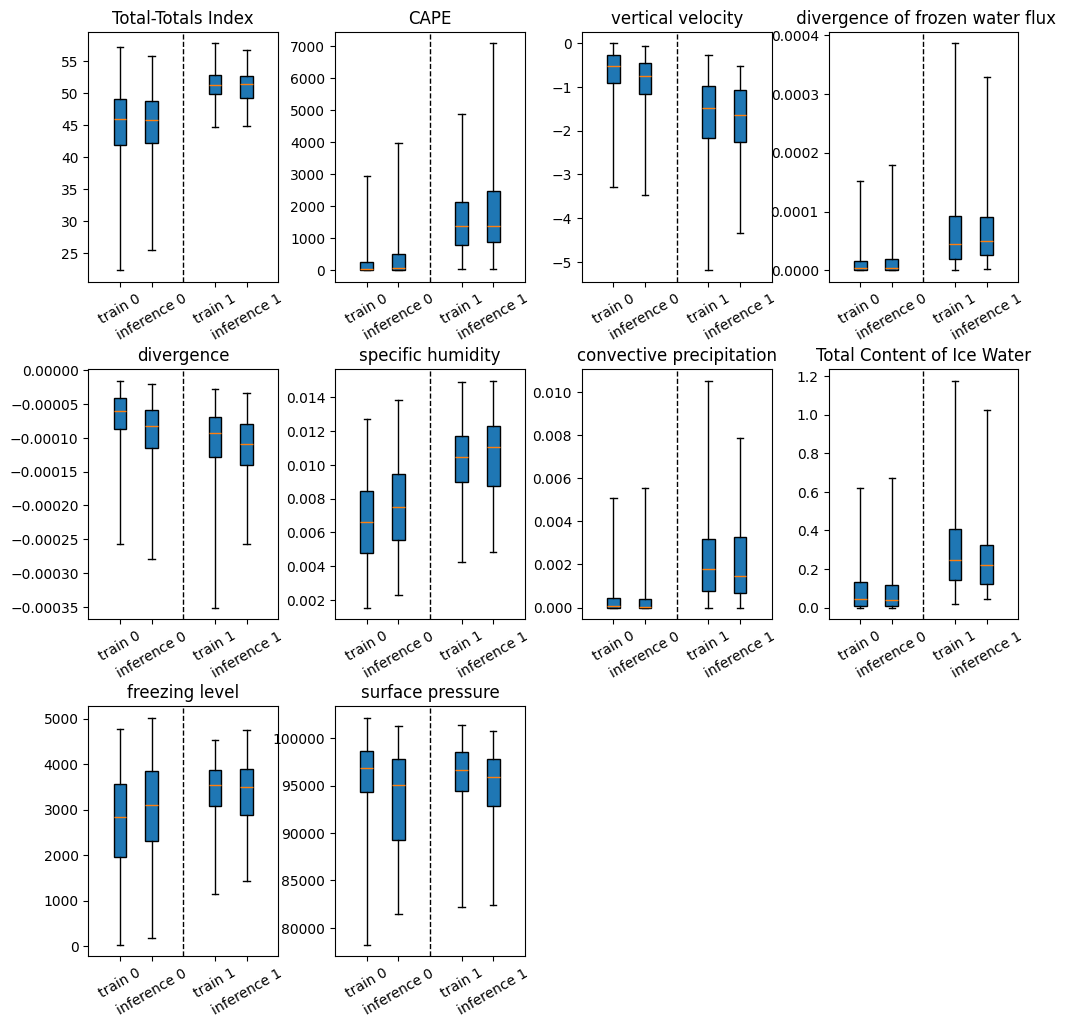

In [46]:
fig=catalonia_for_inference.study_covariate_shift()
fig.savefig("outputs/variable_shift_catalonia.png",dpi=150)

To overcome the covariate shift, we perform the following methodology:
- Using the predictors in both the training and the inference regions, we train a classifier that can diferenciate when a datapoint is in the training or inference domains.
- We apply that classifier to the train domain. Each point in the training domain gets assign with a probability of bein in the inference domain.
- We train the base hail classifier with the training data, as done in the previous section, but this time we give more weight to those points in the training dataset that have a high probability of being in the inference dataset.

A 1-dimensional example of the weighting method is shown in the example below, where training and inference data show some shifting. The training datapoints that are closer to the inference data points have been asinged with a higher weight, exemplified with a larger diameter. Then, using the weighted training dataset, a new classifier will be trained. 

Note that this weighting methodology has a tuning parameter called alpha. This parameter controls how intense the weights are. The higher its value the higher the weigthing will be.

(-0.5, 749.5, 449.5, -0.5)

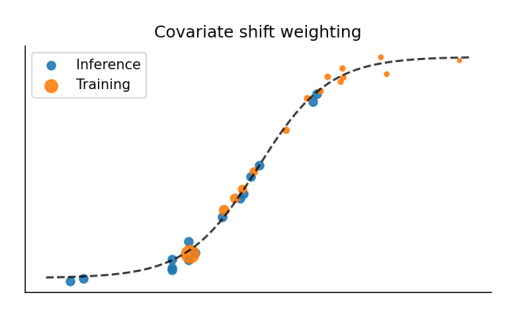

In [47]:
img = matplotlib.image.imread('example_covariate_shift.png')
plt.imshow(img)
plt.axis('off')  

## The weighting methodology to overcome covariate shift
This cell trains a logistic regression model that can calculate the probability that a datapoint is in the inference region. The results of this classifier are shown in the image below. In the first panel, we can see the probabilities asinged to the training and inference datasets. Then, the calibration graph of this classifier is shown. The third and fourth panels correspond to the mean probabilities asigned by the model to the train and inference domains. As expeced, the probability is much higher in the inference domain. One can see that in the training domain, the areas with high probability (i.e: the areas that look like the inference domain and will be weighted more for the base classifier) are closer to the Alps. This will mean that the dataset will have higher weight in mountain regions than lowlands such as Germany that look less like the mountainous terrain of Catalonia. 

After assigning weights, the base XGBoost classifier (with the same parameters of above) is trained in the training domain and used to perform an inference in Catalonia. Then, the MCC and F' metrics are computed. This process is repeated for each alpha value (the strenght of the weghting mechanism) and then repeated multiple times to ensure consistency. 

0
Number of train data points:  21574
Number of inference data points:  1554
AUC ROC:  0.785771763499584
Accuracy at 0.5:  0.6962988585264615


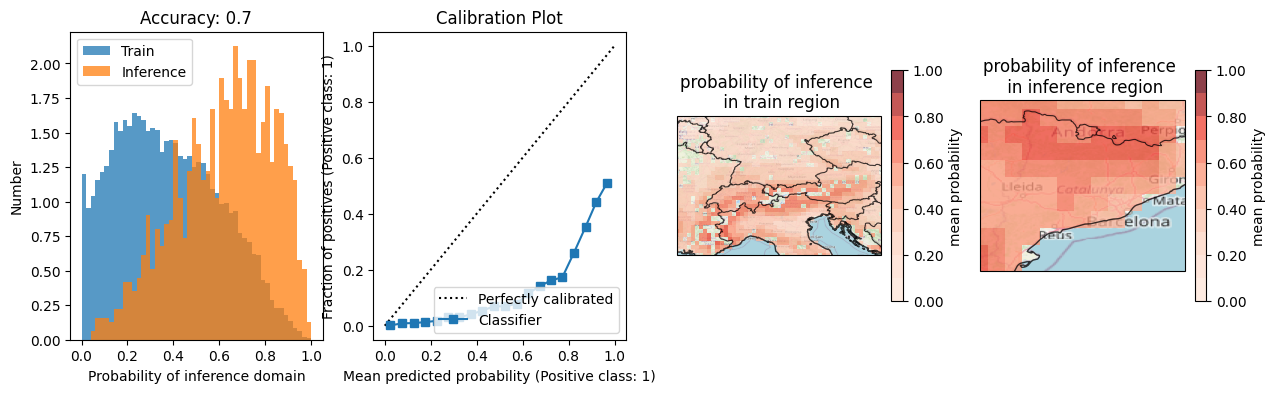

1
Number of train data points:  21574
Number of inference data points:  1554
2
Number of train data points:  21574
Number of inference data points:  1554
3
Number of train data points:  21574
Number of inference data points:  1554
4
Number of train data points:  21574
Number of inference data points:  1554
5
Number of train data points:  21574
Number of inference data points:  1554
6
Number of train data points:  21574
Number of inference data points:  1554
7
Number of train data points:  21574
Number of inference data points:  1554
8
Number of train data points:  21574
Number of inference data points:  1554
9
Number of train data points:  21574
Number of inference data points:  1554
10
Number of train data points:  21574
Number of inference data points:  1554
11
Number of train data points:  21574
Number of inference data points:  1554
12
Number of train data points:  21574
Number of inference data points:  1554
13
Number of train data points:  21574
Number of inference data points:  

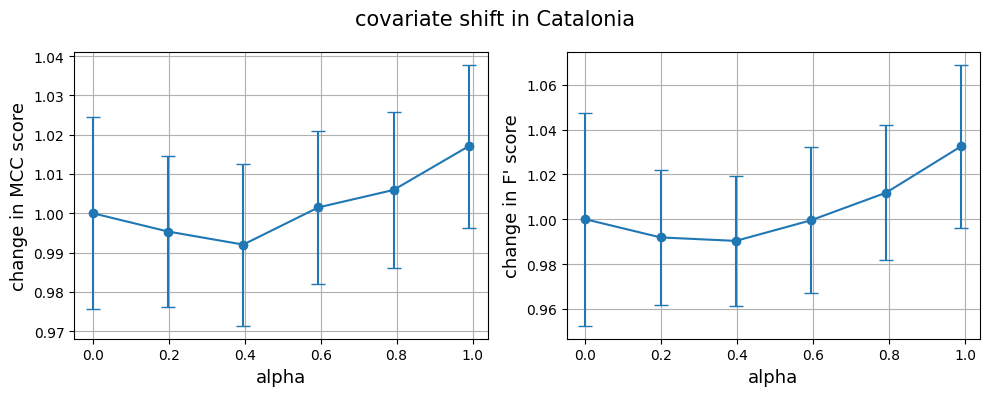

In [32]:
alpha_list=list(np.linspace(0,0.99,6))
mccs=[]
f1s=[]
alphas=[]
for i in range(20):
    print(i)
    training_data=train_data(path_central_europe,np.arange(2015,2022),[2023],model_columns,remove_areas_without_events=True)

    ### process inference data ###
    catalonia_for_inference=inference_data(path_catalonia,np.arange(2015,2024),model_columns,training_data)
    ### calculate the probability that train data is in the inference data 
    if i==0:
        training_data=catalonia_for_inference.calculate_probability_train(training_data,show_plot=True)
    else:
        training_data=catalonia_for_inference.calculate_probability_train(training_data,show_plot=False)        
    
    for alpha in alpha_list:
        classifier=classifier_xgboost(training_data,model_parameters,catalonia_for_inference,alpha,print_scores=False)
        data_inference_catalonia, max_mcc_value, max_f1 = classifier.make_inference(catalonia_for_inference,plot_inference_map=False,print_scores=False)
        mccs.append(max_mcc_value)
        f1s.append(max_f1)
        alphas.append(alpha)

fig,ax=plot_mcc_alpha(alphas, mccs, f1s, "Catalonia")

In the figure above one can see the change in the MCC and F' metrics for different values of alpha, when compared with the baseline (alpha=0, no correction). Altough small alpha values slightly decrease the metrics, once this one passes the 0.5 threshold, the metrics increase up to 2 and 4 % respectively. Note that in the graphs, the point and error bar correspond to the mean and standard deviation of all the models trained. Also note, this effect is specific to our location, variable selection and year choice and it might vary for different regions, variables or years. Overall the weighting methodologies slightly improve the metrics, although this increase is very limited.

# Conclusions

We have built a methodology to model hail ocurrence based on the ERA5 reanalysis data and observations from a hail database such as the ESWD. The model can be used to reconstruct the climatology of hail, which cannot directly be calculated from observations given its inconsistent and poor spatial and temporal coverage. The models can also be used to produce hazard maps for different stakeholders.

One of the key features of the methodology is that the model can be applied to regions with non or poor hail observations. As the convective environments might change from the train and inference regions (covariate shift), we proposed a wighting-base methodology to assist the transfer from training to inference domain. We tested this methodolgy from a transfer learning from Central Europe to Catalonia, obtaining small increases in the metrics. 

